In [20]:
import sys
from pathlib import Path
current_dir = Path.cwd()
project_root = current_dir.parent
sys.path.append(str(project_root))

In [36]:
from utils.getImage import get_image_from_url
from matplotlib import pyplot as plt
import cv2
import numpy as np


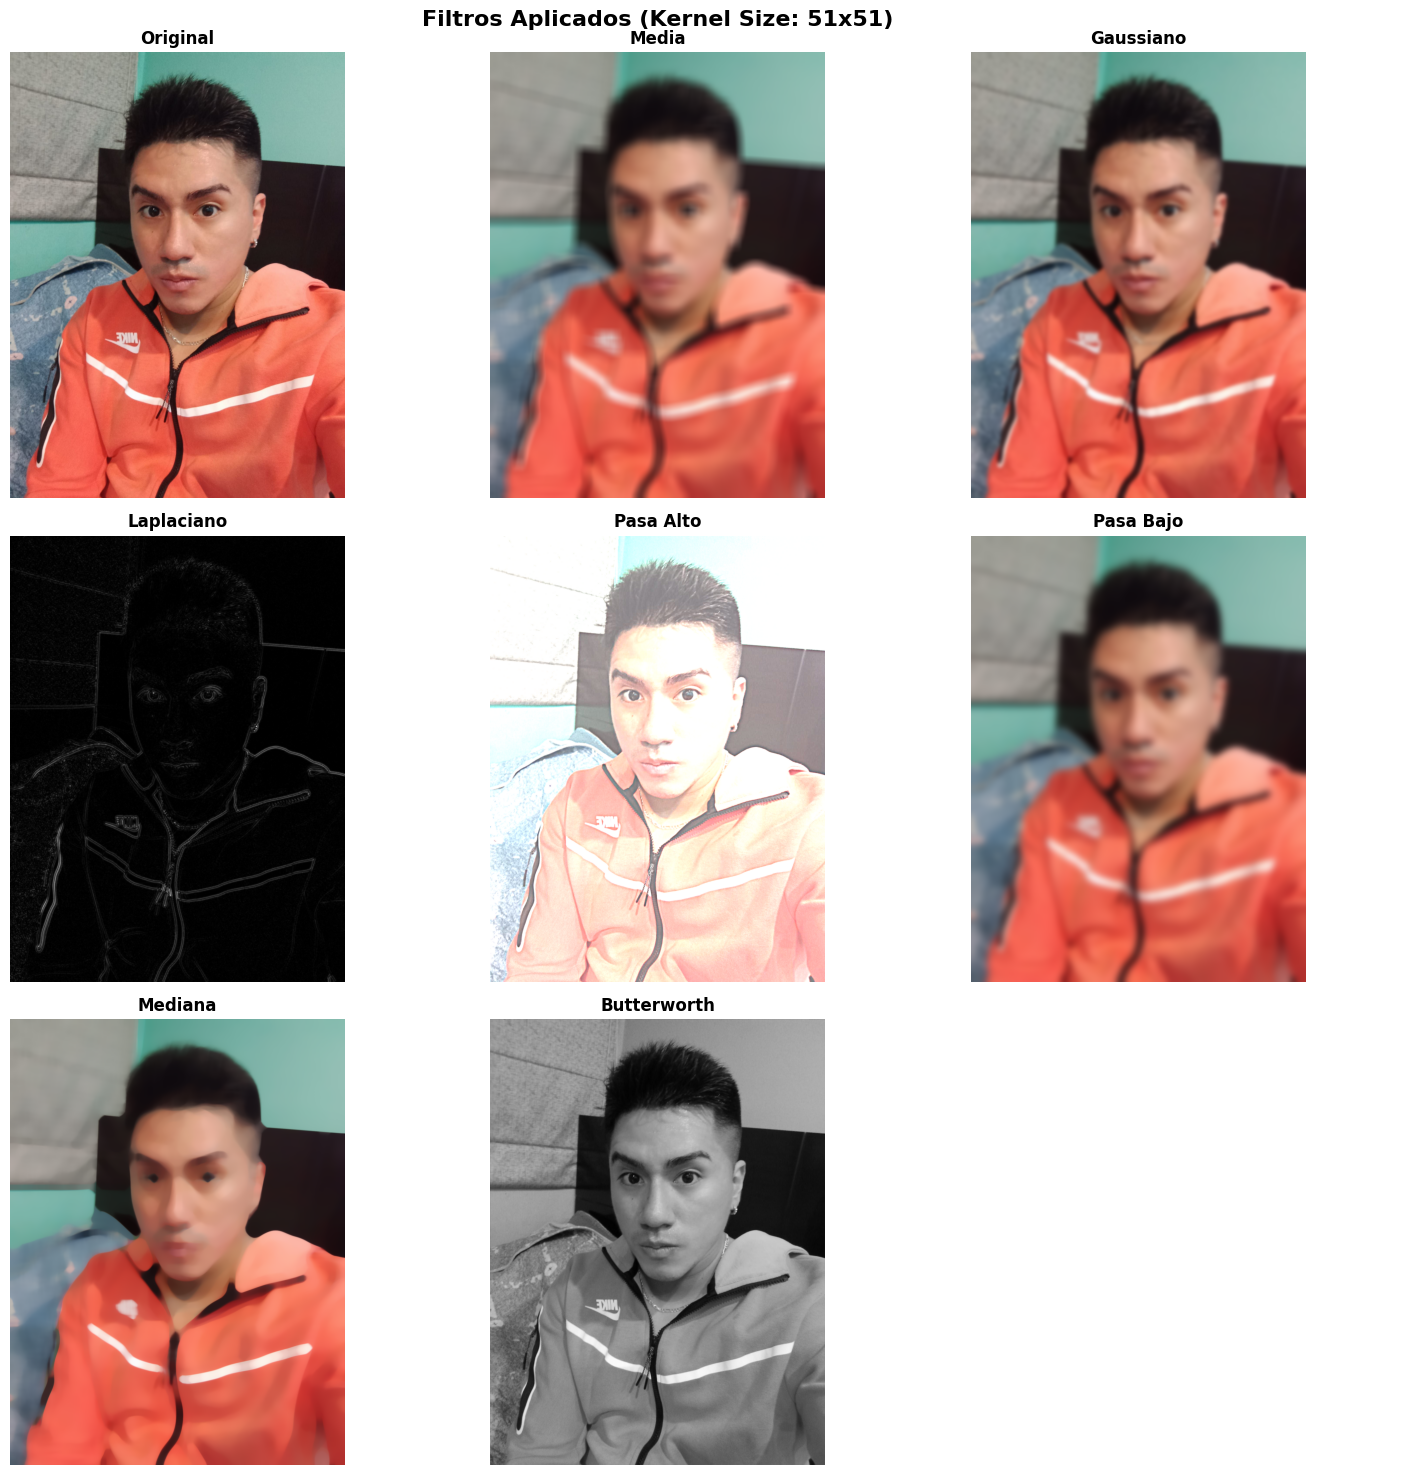

Filtros aplicados con kernel size 51x51:
- Original
- Media
- Gaussiano
- Laplaciano
- Pasa Alto
- Pasa Bajo
- Mediana
- Butterworth


In [52]:
def apply_filters(image, kernel_size=21):     
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)     
    filters = {}          
    
    filters['Original'] = image          
    
    # Filtro Media     
    media_filter = cv2.blur(image, (kernel_size, kernel_size))     
    filters['Media'] = media_filter          
    
    # Filtro Gaussiano     
    gaussian = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)     
    filters['Gaussiano'] = gaussian          
    
    # Filtro Laplaciano     
    laplacian = cv2.Laplacian(gray, cv2.CV_64F, ksize=min(kernel_size, 31))     
    laplacian = np.absolute(laplacian)     
    laplacian = np.uint8(255 * laplacian / np.max(laplacian)) if np.max(laplacian) > 0 else np.uint8(laplacian)     
    filters['Laplaciano'] = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2RGB)          
    
    # Filtro Pasa Alto     
    if kernel_size <= 3:
        kernel_high = np.array([[-1,-1,-1],                            
                               [-1, 8,-1],                            
                               [-1,-1,-1]])
        high_pass = cv2.filter2D(image, -1, kernel_high)
    else:
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        high_pass = cv2.addWeighted(image, 2.0, blurred, -1.0, 128)
        high_pass = np.clip(high_pass, 0, 255).astype(np.uint8)
    filters['Pasa Alto'] = high_pass          
    
    # Filtro Pasa Bajo     
    low_pass = cv2.GaussianBlur(image, (kernel_size*2+1, kernel_size*2+1), 0)     
    filters['Pasa Bajo'] = low_pass          
    
    # Filtro Mediana     
    median = cv2.medianBlur(image, kernel_size if kernel_size % 2 == 1 else kernel_size+1)     
    filters['Mediana'] = median          
    
    # Filtro Butterworth     
    f_transform = np.fft.fft2(gray)     
    f_shift = np.fft.fftshift(f_transform)          
    
    rows, cols = gray.shape     
    crow, ccol = rows // 2, cols // 2          
    
    u = np.arange(rows).reshape(-1, 1) - crow     
    v = np.arange(cols) - ccol     
    D = np.sqrt(u**2 + v**2)          
    
    D0 = kernel_size * 10     
    n = 2     
    H = 1 / (1 + (D / D0)**(2*n))          
    
    f_shift_filtered = f_shift * H     
    f_ishift = np.fft.ifftshift(f_shift_filtered)     
    butterworth = np.fft.ifft2(f_ishift)     
    butterworth = np.real(butterworth)     
    butterworth = np.uint8(np.clip((butterworth - butterworth.min()) * 255 / (butterworth.max() - butterworth.min()), 0, 255))     
    filters['Butterworth'] = cv2.cvtColor(butterworth, cv2.COLOR_GRAY2RGB)          
    
    return filters

#_, color_image, _ = get_image_from_url("https://cdn.royalcanin-weshare-online.io/tlYzqG0BBKJuub5qNVnB/v1/67-es-l-cat-in-a-sofa-thinking-getting-dog-gato-adecuado") 
_, color_image, _ = get_image_from_url("https://www.infobae.com/new-resizer/IZdSCWJPT9s0u2c16cYyCDBW8Tc=/arc-anglerfish-arc2-prod-infobae/public/H4KDNLXATBGW5NPXJUJS5I3OQY.jpg") 
image_array = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)  

kernel_size = 51
filters = apply_filters(image_array, kernel_size)  

fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 
fig.suptitle(f'Filtros Aplicados (Kernel Size: {kernel_size}x{kernel_size})', fontsize=16, fontweight='bold')  

axes_flat = axes.flatten()  

for i, (filter_name, filtered_image) in enumerate(filters.items()):     
    if i < len(axes_flat):         
        axes_flat[i].imshow(filtered_image)         
        axes_flat[i].set_title(filter_name, fontweight='bold', fontsize=12)         
        axes_flat[i].axis('off')  

for i in range(len(filters), len(axes_flat)):     
    axes_flat[i].axis('off')  

plt.tight_layout() 
plt.show()  

print(f"Filtros aplicados con kernel size {kernel_size}x{kernel_size}:") 
for name in filters.keys():     
    print(f"- {name}")